In [7]:
import os
import wfdb
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def load_mitbih_dataset(path):
    # List of ECG annotations of interest
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

    # Storage for ECG segments and their corresponding labels
    X = []
    y = []

    # Map annotations to integers for one-hot encoding
    annot_to_int = {annot: i for i, annot in enumerate(annots_list)}

    # Read the record names from the RECORDS file
    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    # Initialize a scaler to normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Process each record
    for record_name in record_list:
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')
        
        # Get the first channel of the ECG signals
        signal = record.p_signal[:, 0]
        
        # Iterate over each annotated beat
        for sym, loc in zip(annotation.symbol, annotation.sample):
            if sym in annots_list:
                label = annot_to_int[sym]
                win_size = 625  # Half-window size for segmenting the signal
                
                # Ensure the segment does not go out of bounds
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    segment = signal[loc - win_size: loc + win_size]
                    # Normalize the segment
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    X.append(segment)
                    y.append(label)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = to_categorical(y, num_classes=len(annots_list))
    
    return X, y

def reshape_data_for_resnet(X):
    # Reshape data from 1D to 2D format for ResNet50 input
    num_samples = X.shape[0]
    # Example reshaping method: treat each segment as a 1D "image" with one channel
    X_reshaped = X.reshape(num_samples, 25, 50, 1)
    return X_reshaped

# Load dataset
X, y = load_mitbih_dataset("/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/")
# Reshape for ResNet50
X = reshape_data_for_resnet(X)


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_prepare_mitbih_dataset(path):
    # Load the dataset using the previously defined function
    X, y = load_mitbih_dataset(path)

    # Reshape data from 1D to 2D format suitable for ResNet
    num_samples = X.shape[0]
    # Example reshaping: creating a pseudo-image of shape (25, 50, 1)
    X_reshaped = X.reshape(num_samples, 25, 50, 1) 
    return X_reshaped, y

# # Load and prepare your dataset
# X, y = load_and_prepare_mitbih_dataset("/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/")

# # Step 1: Perform the split once
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # Step 2: Save the split data to disk for later use
# np.save('./X_train.npy', X_train)
# np.save('./X_test.npy', X_test)
# np.save('./y_train.npy', y_train)
# np.save('./y_test.npy', y_test)


In [9]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall

def identity_block(input_tensor, kernel_size, filters):
    # Identity block: preserves input size, uses three convolutional layers
    filters1, filters2, filters3 = filters
    
    # First component of main path: 1x1 convolutions
    x = Conv2D(filters1, (1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second component: 3x3 convolution, same padding keeps size constant
    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third component: 1x1 convolutions adjust number of filters to match shortcut path
    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def convolutional_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    # Convolutional block: changes input size, uses three convolutional layers
    filters1, filters2, filters3 = filters

    # First component of main path: 1x1 convolutions with stride to reduce dimensions
    x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second component: 3x3 convolution, same padding keeps size constant
    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third component: 1x1 convolutions, no stride, adjust filters
    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)

    # Shortcut path: 1x1 convolutions with stride to match main path dimensions
    shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    # Final step: Add shortcut to the main path, and pass it through ReLU activation
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet50_model(num_classes, input_shape=(25, 50, 1), optimizer_type='adam', learning_rate=0.001):
    # Define the input layer to the model with the expected shape of each input
    inputs = Input(shape=input_shape)
    
    # Initial convolutional layer followed by max-pooling to reduce dimensionality
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # First set of ResNet blocks: one convolutional block followed by identity blocks
    x = convolutional_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    # Second set of ResNet blocks: increasing number of filters
    x = convolutional_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    # Global average pooling replaces traditional dense layers
    x = GlobalAveragePooling2D()(x)

    # Final dense layer for classification
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = Dense(num_classes, activation='softmax')(x)

    # Select optimizer: Adam or SGD
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    # Compile the model specifying optimizer, loss function, and evaluation metrics
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    return model


Training new model...
Epoch 1/20


2024-05-09 01:23:37.747964: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-09 01:23:39.045590: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fed5d964020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-09 01:23:39.045635: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-09 01:23:39.045646: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-09 01:23:39.057624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715243019.169213  238729 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2733/2733 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9245 - precision_3: 0.9431 - recall_3: 0.9074
Epoch 1: val_loss improved from inf to 0.17519, saving model to ./final_model_resnet50.h5
2733/2733 [==============================] - 104s 34ms/step - loss: 0.2887 - accuracy: 0.9245 - precision_3: 0.9431 - recall_3: 0.9074 - val_loss: 0.1752 - val_accuracy: 0.9536 - val_precision_3: 0.9576 - val_recall_3: 0.9496 - lr: 0.0010
Epoch 2/20


/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2732/2733 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9627 - precision_3: 0.9690 - recall_3: 0.9565
Epoch 2: val_loss improved from 0.17519 to 0.12000, saving model to ./final_model_resnet50.h5
2733/2733 [==============================] - 91s 33ms/step - loss: 0.1463 - accuracy: 0.9627 - precision_3: 0.9690 - recall_3: 0.9565 - val_loss: 0.1200 - val_accuracy: 0.9669 - val_precision_3: 0.9728 - val_recall_3: 0.9603 - lr: 0.0010
Epoch 3/20
2732/2733 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9718 - precision_3: 0.9759 - recall_3: 0.9680
Epoch 3: val_loss did not improve from 0.12000
2733/2733 [==============================] - 91s 33ms/step - loss: 0.1080 - accuracy: 0.9718 - precision_3: 0.9759 - recall_3: 0.9680 - val_loss: 0.1251 - val_accuracy: 0.9662 - val_precision_3: 0.9701 - val_recall_3: 0.9628 - lr: 0.0010
Epoch 4/20
2733/2733 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9767 - precision_3: 0.9

TypeError: 'History' object is not subscriptable

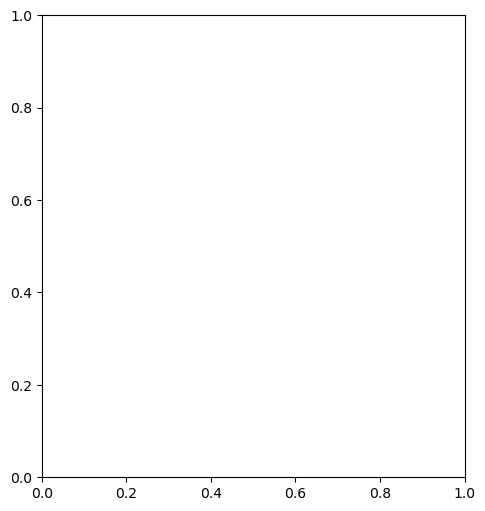

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import json

def train_and_save_model():
    # Load pre-split data from disk, formatted as 2D arrays (reshaped during preprocessing)
    X_train = np.load('./X_train.npy')
    X_test = np.load('./X_test.npy')
    y_train = np.load('./y_train.npy')
    y_test = np.load('./y_test.npy')
    
    # Define paths for the model and training history files
    model_path = './final_model_resnet50.h5'
    history_path = './model_history_resnet50.json'

    # Check if the model and history files already exist to avoid retraining
    if os.path.exists(model_path) and os.path.exists(history_path):
        print("Model and training history already exist. Loading...")
        model = keras.models.load_model(model_path)  # Load the pre-trained model
        with open(history_path, 'r') as f:
            history = json.load(f)  # Load the training history
    else:
        print("Training new model...")
        # Initialize and compile the ResNet50 model
        model = create_resnet50_model(num_classes=y_train.shape[1], input_shape=(25, 50, 1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        # Set up callbacks for saving the best model, early stopping, and reducing learning rate on plateau
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
        ]

        # Train the model with adjusted batch size and epochs suitable for model complexity
        history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                            validation_data=(X_test, y_test), callbacks=callbacks)
        print("Training completed. Model saved.")
        # Convert the training history to native Python types for better handling
        history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
        # Save the training history to a JSON file for later analysis
        with open(history_path, 'w') as f:
            json.dump(history_dict, f)
            print("Training history saved.")

    return model, history

def plot_learning_curves(history):
    # Plot the learning curves for accuracy and loss to visualize performance over epochs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

if __name__ == "__main__":
    model, history = train_and_save_model()
    plot_learning_curves(history)


Model loaded successfully.
684/684 [==============================] - 6s 8ms/step - loss: 0.0519 - accuracy: 0.9878 - precision_3: 0.9888 - recall_3: 0.9867
Test Loss, Test Accuracy, and other metrics: [0.05187075585126877, 0.9877848029136658, 0.9887681603431702, 0.986732542514801]
684/684 [==============================] - 5s 6ms/step


/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     14995
           L       1.00      0.99      1.00      1594
           R       0.99      1.00      1.00      1500
           e       0.00      0.00      0.00         2
           j       0.81      0.80      0.80        49
           S       0.00      0.00      0.00         1
           A       0.95      0.89      0.92       467
           a       0.66      0.70      0.68        27
           J       0.00      0.00      0.00        12
           V       0.98      0.97      0.97      1444
           E       1.00      1.00      1.00        16
           F       0.89      0.70      0.78       145
           /       1.00      1.00      1.00      1408
           f       0.90      0.96      0.93       182
           Q       1.00      0.06      0.12        16

    accuracy                           0.99     21858
   macro avg       0.74      0.67      0.68     21858
we

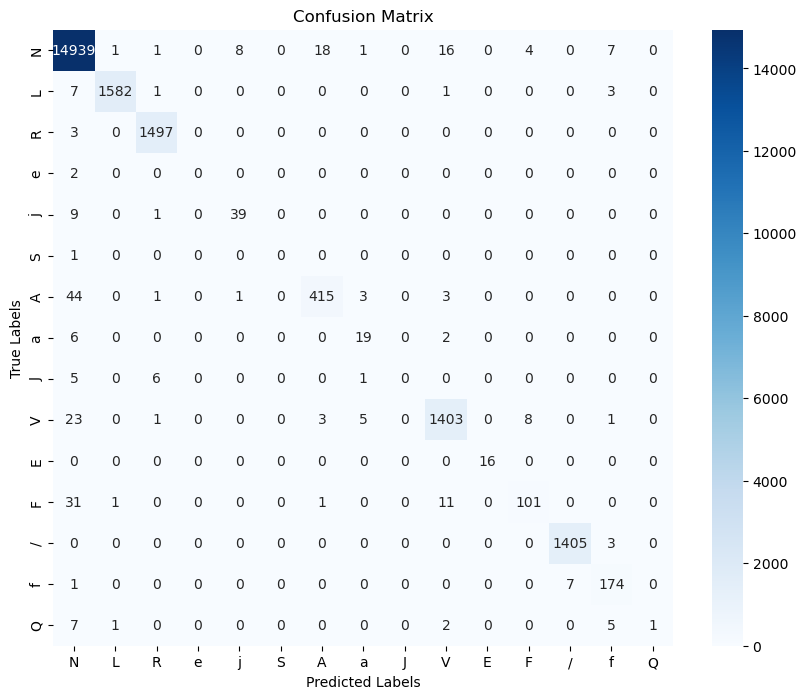

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Define the class labels based on the annotations in your dataset
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

def load_and_evaluate(threshold=0.5):
    # Load the preprocessed test data from files
    X_test = np.load('./X_test.npy')
    y_test = np.load('./y_test.npy')

    # Reshape the test data to match the input shape expected by the ResNet model (25x50, with 1 channel)
    X_test = X_test.reshape((X_test.shape[0], 25, 50, 1))

    # Path to the trained model
    model_path = './final_model_resnet50.h5'
    if not os.path.exists(model_path):
        print("Model file not found!")
        return

    # Load the trained model
    model = keras.models.load_model(model_path)
    print("Model loaded successfully.")

    # Evaluate the model on the test dataset
    results = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test Loss, Test Accuracy, and other metrics: {results}')

    # Predict the classes of the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate and print a classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
    print("\nClassification Report:")
    print(report)

    # Identify classes where the F1 score is below the specified threshold
    report_dict = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, output_dict=True)
    underperforming_classes = [cls for cls, metrics in report_dict.items() if cls in class_labels and metrics['f1-score'] < threshold]
    print(f"Underperforming classes: {underperforming_classes}")

    # Save the list of underperforming classes for future reference
    with open('underperforming_classes.json', 'w') as f:
        json.dump(underperforming_classes, f)
        print("Underperforming classes saved.")

    # Plot a confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return y_pred_classes

if __name__ == "__main__":
    predicted_classes = load_and_evaluate()
